In [1]:
import numpy  as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import DiscreteCurves
from geomstats.geometry.euclidean import Euclidean

INFO: Using numpy backend


## Functions

In [3]:
def length(curve):
    n_points = curve.shape[0]
    velocity = n_points * (curve[1:] - curve[:-1])
    velocity_norm = np.linalg.norm(velocity, axis=1)
    return np.sum(velocity_norm) / n_points


def resample(curve, n_points_resampled):
    '''Resample curve.
    
    c [n_points, dim] : n points d'une courbe
    N [1, 1] : nombre de points - 1 pour la reparamétrisation par longueur d'arc
    C [dim, n_points_resampled+1] : nouveaux points répartis uniformément par rapport à la longueur d'arc
    '''
    n_points = curve.shape[0]
    dim = curve.shape[1]
    if n_points == 1:
        resampled_curve = np.ones((dim, n_points_resampled + 1)) * curve
    else:
        delta = np.zeros(n_points)
        for i in range(1, n_points):
            delta[i] = np.linalg.norm(curve[i, :] - curve[i-1, :], axis=0)

        cumdel = np.cumsum(delta) / sum(delta)
        newdel = np.linspace(0., 1., n_points_resampled + 1)

        resampled_curve = np.zeros((n_points_resampled + 1, dim))
        for k in range(dim):
            cs = CubicSpline(cumdel, curve[0:n_points, k])
            resampled_curve[:, k] = cs(newdel)
    return resampled_curve


def scalar_product(tangent_vec_1, tangent_vec_2, base_curve, a=1, b=1/2):
    """Compute scalar product of tangent_vec at base curve for the elastic a,b metric.
    """
    n_points = base_curve.shape[0]
    dim = base_curve.shape[1]
    dtangent_vec_1 = n_points * (tangent_vec_1[1:, :] - tangent_vec_1[:-1, :])
    dtangent_vec_2 = n_points * (tangent_vec_2[1:, :] - tangent_vec_2[:-1, :])
    velocity_vec = n_points * (base_curve[1:, :] - base_curve[:-1, :])
    velocity_norm = np.linalg.norm(velocity_vec, axis=1)
    unit_velocity_vec = np.einsum('ij,i->ij', velocity_vec, 1 / velocity_norm)
    integrand = (a**2 * np.sum(dtangent_vec_1 * dtangent_vec_2, axis=1)
        + (b**2 - a**2) * np.sum(dtangent_vec_1 * unit_velocity_vec, axis=1)
        * np.sum(dtangent_vec_2 * unit_velocity_vec, axis=1)) / velocity_norm
    scalar_prod = np.sum(integrand) / n_points
    return scalar_prod


def hvsplit(path_of_curves, a=1, b=1/2):
    '''
    Computes the splitting of the speed vector field s|->cs(s) of a path of
    curves s|->c(s) in horizontal and vertical parts : cs_ver(s) = M(s)v(s)
    and cs_hor(s) = cs(s) - M(s)v(s).

    Input :
    - c [2x(n+1)x(m+1)] : path of curves in R^2.
    - verif [1 or 0]    : computes how orthogonal the horizontal and vertical
                           parts actually are and checks that M is sol of ODE

    Output :
    - M [(n+1)xm]   : defines splitting of the speed vector of the path c
                       cs_ver(s)=M(s)v(s), cs_hor(s)=cs(s)-M(s)v(s).
    - K [2x(n+1)xm] : tau(k,j) = log_H(c(k,j),c(k+1,j))
    ... if verif ==1 :
    - L [1x1]       : length of c
    - SP_cs [mx1]   : norm of speed vector SP_cs = G(cs,cs)
    - SP_hor [mx1]  : norm of horizont part SP_hor = G(cs-Mv,cs-Mv)
    - SP_ver [mx1]  : norm of vertical part SP_ver = G(Mv,Mv)
    - SP_hv [mx1]   : inner product SP_hv = G(cs-Mv,Mv)
    '''
    n_times = path_of_curves.shape[0] - 1 
    n_points = path_of_curves.shape[1] - 1 
    dim = path_of_curves.shape[2]

    # compute tau [mx(n+1)xdim] : tau(j,k) = log(c(j,k),c(j,k+1))
    tau = np.zeros((n_times, n_points + 1, dim))
    tau[:, :-1, :] = path_of_curves[:-1, 1:, :] - path_of_curves[:-1, :-1, :]
    tau[:, -1, :] = tau[:, -2, :]

    # compute K [mx(n+1)] : K(j,k) = |tau(j,k)|
    K = np.linalg.norm(tau, axis=-1)

    # compute v [mx(n+1)xdim] : v(j,k) = tau(j,k)/K(j,k)
    v = gs.einsum('ijk,ij->ijk', tau, 1/K)

    # compute lambda [mxn] : lambda = <v(j,k+1),v(j,k)>
    v_prod = v[:, 1:, :] * v[:, :-1, :]
    lambd = np.sum(v_prod, axis=-1)

    # compute cs [mx(n+1)xdim]
    cs = n_times * (path_of_curves[1:,:,:] - path_of_curves[:-1, :, :])

    # compute Nstau [mxnxdim]
    Nstau = cs[:, 1:, :] - cs[:, 0:-1, :]

    # compute A,B,C,D [mx(n-1)]
    A = K[:, 1:-1] / K[:, :-2] * lambd[:, :-1]
    B = -(1 + K[:, 1:-1] / K[:, :-2] * ((a/b)**2 + (1 - (a/b)**2) * lambd[:, :-1]**2))
    C = lambd[:, 1:]

    d = (a/b)**2 * v[:, 1:-1, :] + (1 - (a/b)**2) * gs.einsum('ij,ijk->ijk', lambd[:, :-1], v[:, :-2, :])
    Nstau_vk = np.sum(Nstau[:, 1:, :] * v[:, 1:-1, :], axis=-1)
    Nstau_d  = np.sum(Nstau[:, :-1, :] * d, axis=-1)
    D = Nstau_vk - K[:, 1:-1] / K[:, :-2] * Nstau_d

    # compute M [mx(n+1)] : cs(k,j)^{ver} = M(k,j)v(k,j)
    M = np.zeros((n_times, n_points + 1))
    for j in range(n_times):
        LL = np.diag(A[j, 1:], -1) + np.diag(B[j, :]) + np.diag(C[j, :-1], 1)
        M[j, 1:-1] = np.linalg.solve(LL, D[j, :])

    cs_ver = np.einsum('ij,ijk->ijk', M, v)
    cs_hor = cs - cs_ver
    
    return M, K, cs_ver, cs_hor


def horizontal_geodesic(curve_a, curve_b, n_times=10, threshold = 1e-3):
    """Compute the horizontal geodesic between curve_a and curve_b in the fiber bundle
    induced by the action of reparameterizations.
    """
    dim = curve_a.shape[1]
    Rdim = Euclidean(dim)
    curves = DiscreteCurves(ambient_manifold=Rdim)
    
    n_points = curve_a.shape[0] - 1
    t_space = np.linspace(0., 1., n_points + 1)
    t_time = np.linspace(0., 1., n_times + 1)
    
    spline_a = CubicSpline(t_space, curve_a, axis=0)
    spline_b = CubicSpline(t_space, curve_b, axis=0)

    initial_curve = curve_a.copy()
    end_curve = curve_b.copy()
    gap = 1.

    while(gap > threshold):
        
        # Compute geodesic path of curves
        srv_geod_fun = curves.square_root_velocity_metric.geodesic(
            initial_curve=initial_curve, end_curve=end_curve)
        geod = srv_geod_fun(t_time)
        M, K, cs_ver, cs_hor = hvsplit(geod)

        # Compute path of reparameterizations
        phi      = np.zeros((n_times + 1, n_points + 1))
        phi_t    = np.zeros((n_times + 1, n_points))
        phi_s    = np.zeros((n_times, n_points))
        test_phi = np.zeros(n_times)
        phi[0, :] = np.linspace(0., 1., n_points + 1)
        phi[:, -1] = np.ones(n_times + 1)
        for j in range(n_times):
            phi_t[j, 0] = n_points * (phi[j, 1] - phi[j, 0])
            phi_s[j, 0] = phi_t[j, 0] * M[j, 0] / (n_points * K[j, 0])
            phi[j+1, 0] = phi[j, 0] + 1/n_times * phi_s[j, 0]
            for k in range(1, n_points):# Matlab k = 2 : n
                if M[j, k]>0:
                    phi_t[j, k] = n_points * (phi[j, k+1] - phi[j, k])
                else:
                    phi_t[j, k] = n_points * (phi[j, k] - phi[j, k-1])

                phi_s[j, k] = phi_t[j, k] * M[j, k] / (n_points * K[j, k])
                phi[j+1, k] = phi[j, k] + 1/n_times * phi_s[j, k]

            test_phi[j] = np.sum( phi[j+1, 2:] - phi[j+1, 1:-1] < 0 )
            if np.any(test_phi):
                print(test_phi)
                print('Warning: phi(s) is non increasing for at least one time s.')
        
        # Compute horizontal path of curves
        horizontal_path = np.zeros(geod.shape)
        horizontal_path[0, :, :] = curve_a
        for j in range(1, n_times):
            spline_j = CubicSpline(t_space, geod[j, :, :], axis=0)
            phi_inverse = CubicSpline(phi[j, :], t_space)
            horizontal_path[j, :, :] = spline_j(phi_inverse(t_space))
        
        phi_inverse = CubicSpline(phi[-1, :], t_space)
        horizontal_path[-1, :, :] = spline_b(phi_inverse(t_space))
        
        new_end_curve = horizontal_path[-1, :, :]
        gap = (np.sum(np.linalg.norm(new_end_curve - end_curve, axis=-1)**2))**(1/2)
        end_curve = new_end_curve.copy()
        print(gap)
        
    return horizontal_path

## Example in R2

In [4]:
R2 = Euclidean(dim=2)
curves2D = DiscreteCurves(ambient_manifold=R2)

In [5]:
n_points = 10
R = 2
theta = np.linspace(0., gs.pi, n_points+1)
curve_a = gs.array([1 + R * gs.sin(theta), 3 + R * gs.cos(theta)]).T
curve_b = gs.array([5 * gs.ones(n_points+1), gs.linspace(5., 1., n_points+1)]).T

In [6]:
print(curves2D.belongs(curve_a))
print(curves2D.belongs(curve_b))

True
True


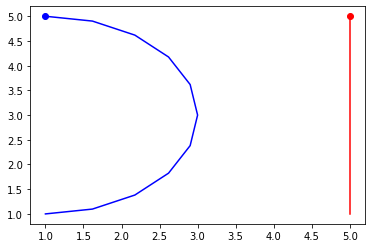

In [7]:
plt.figure()
plt.plot(curve_a[:, 0], curve_a[:, 1], 'b')
plt.plot(curve_b[:, 0], curve_b[:, 1], 'r')
plt.plot(curve_a[0, 0], curve_a[0, 1], 'ob')
plt.plot(curve_b[0, 0], curve_b[0, 1], 'or')
plt.show()

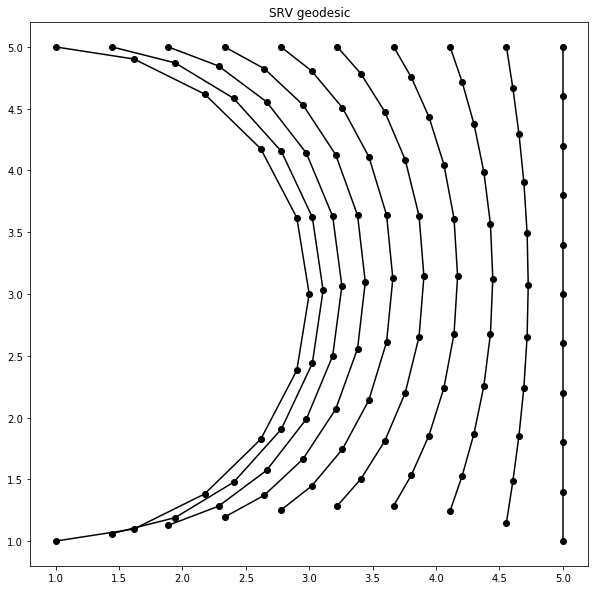

In [8]:
srv_geod_fun = curves2D.square_root_velocity_metric.geodesic(initial_curve=curve_a, end_curve=curve_b)

n_times = 10
t = gs.linspace(0., 1., n_times)
srv_geod = srv_geod_fun(t)

plt.figure(figsize=(10, 10))
for i in range(n_times):
    plt.plot(srv_geod[i, :, 0], srv_geod[i, :, 1], 'o-', c='k')
plt.title('SRV geodesic')
plt.show()

1.044643013082445
0.6480990512509811
0.38787012610841715
0.23085271258528414
0.1364941586955365
0.08525431796927724
0.05298887739960604
0.031124706348094788
0.019014980479531596
0.015916895444290754
0.016271602287656114
0.015832511977398055
0.013901608386742603
0.011027789631067661
0.007961986916256629
0.0052680881034059155
0.003226957897191983
0.001914377024769954
0.0012399109196713546
0.0009347037389784127


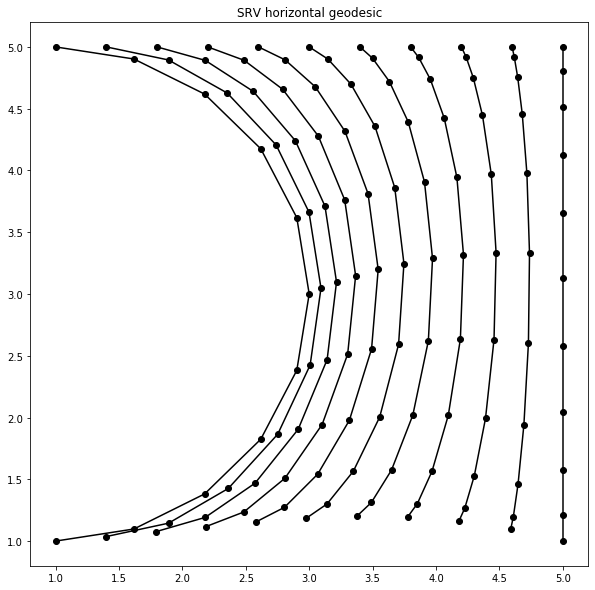

In [9]:
horizontal_geod = horizontal_geodesic(curve_a, curve_b, 10)

plt.figure(figsize=(10,10))
for j in range(n_times + 1):
    plt.plot(horizontal_geod[j, :, 0], horizontal_geod[j, :, 1], '-ok')
plt.title('SRV horizontal geodesic')
plt.show()

## Example in R3

In [10]:
R3 = Euclidean(dim=3)
curves3D = DiscreteCurves(ambient_manifold=R3)

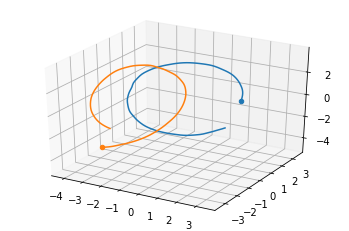

In [12]:
n_files = 10
n_points_F = np.zeros(n_files)
for i in range(n_files):
    F = np.loadtxt('data/femme{}.txt'.format(i+1))
    n_points_F[i] = F.shape[0]

ns = np.min(n_points_F) - 1
F = np.zeros((n_files, int(ns), 3))
for i in range(n_files):
    F1 = np.loadtxt('data/femme{}.txt'.format(i+1))
    F[i, :, :] = F1[np.floor(np.linspace(0, F1.shape[0]-1, int(ns))).astype('int'), :] - F1[0]
    
curve_1 = F[1, 199:399, :]
curve_2 = F[0, 199:399, :]
curve_2 = np.flip(curve_2, axis=0) + np.array([-1, 0, 0])
n = 100
curve_1 = resample(curve_1, n)
curve_2 = resample(curve_2, n)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(curve_1[:, 0], curve_1[:, 1], curve_1[:, 2])
ax.plot(curve_2[:, 0], curve_2[:, 1], curve_2[:, 2])
ax.scatter(curve_1[0, 0], curve_1[0, 1], curve_1[0, 2])
ax.scatter(curve_2[0, 0], curve_2[0, 1], curve_2[0, 2])
plt.show()

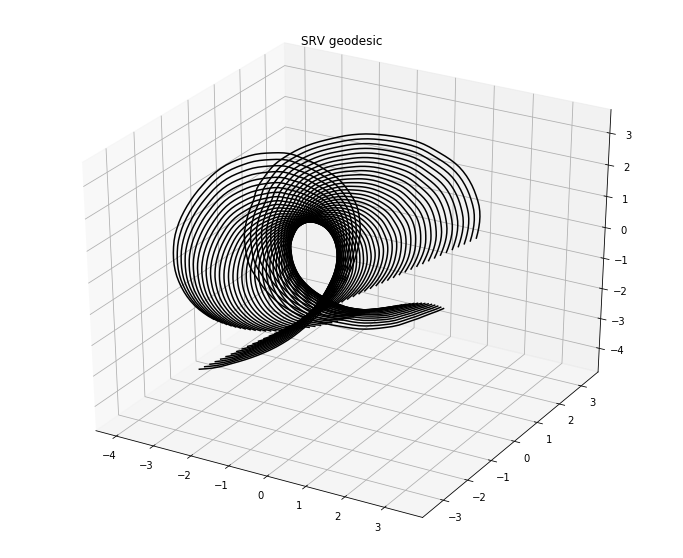

In [13]:
srv_geod_fun = curves3D.square_root_velocity_metric.geodesic(initial_curve=curve_1, end_curve=curve_2)

n_times = 50
t = gs.linspace(0., 1., n_times + 1)
srv_geod = srv_geod_fun(t)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
for i in range(n_times):
    ax.plot(srv_geod[i, :, 0], srv_geod[i, :, 1],  srv_geod[i, :, 2], 'k')
plt.title('SRV geodesic')
plt.show()

26.81767330611076
16.90437932341529
10.616338221938799
6.269717072337755
4.104118240817627
2.436450183741216
1.4184030280140123
1.041275584048576
0.8650225232981016
0.6485482221200509
0.4524137212697436
0.2887403148097791
0.17571465288384613
0.10281965946956037
0.05860734931846225
0.03262277117996484
0.01781863395773542
0.009568781521975466
0.005064679285127731
0.0026443686551520483
0.001363597818990569
0.0006945879369043528


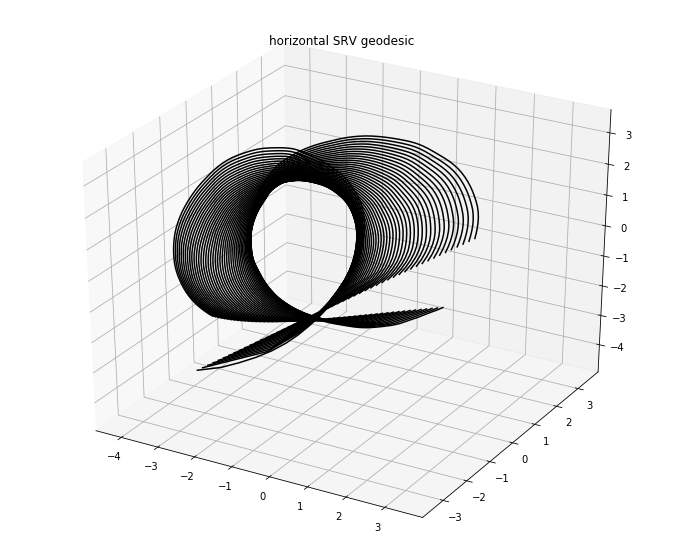

In [16]:
horizontal_geod = horizontal_geodesic(curve_1, curve_2, 50)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
for i in range(n_times+1):
    ax.plot(horizontal_geod[i, :, 0], horizontal_geod[i, :, 1],  horizontal_geod[i, :, 2], 'k')
plt.title('horizontal SRV geodesic')
plt.show()

## Tests

In [18]:
def test_hvsplit(curve_a, curve_b, tol=1e-10):

    srv_geod_fun = curves2D.square_root_velocity_metric.geodesic(
        initial_curve=curve_a, end_curve=curve_b)
    
    n_times = 10
    t = np.linspace(0., 1., n_times + 1)
    path_of_curves = srv_geod_fun(t)
    
    M, K, cs_ver, cs_hor = hvsplit(path_of_curves)

    for j in range(n_times):
        assert np.abs(scalar_product(cs_ver[j], cs_hor[j], path_of_curves[j])) < tol
        
test_hvsplit(curve_a, curve_b)